## Wine quality prediction with Neural Net


Create a 3 layer linear network RELU activation functions with a cross-entropy output layer classifying the wine quality using basic numpy. This should be done without using higher-level packages. All gradients and loss functions need to be defined and explained. The functions and gradients need to be defined to calculate the feedforward and backward propagation. Basic machine learning consideration when preprocessing and handling data need to be taken in consideration. Lines of code should be commented thoroughly to show understanding.
Dataset:​https://drive.google.com/file/d/1xJmZpZvxNo7X52QSHvmP34k7nVnwBdyT/view?usp=s haring

## Investigating the dataset

In [16]:
#import libraries
import pandas as pd
from pandas import Timestamp
import numpy as np
from random import random, seed, randrange
from abc import ABCMeta, abstractmethod
import warnings
warnings.filterwarnings("ignore")

#plotting and visualizing libs
import seaborn as sns
import matplotlib.pyplot as plt


#read the csv file
wine = pd.read_csv('winequalityN.csv')
wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,C
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,C
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,C
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,C
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,C


In [17]:
# Check the correlation between columns
corr = wine.corr(method = 'pearson')
corr.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,0.220172,0.323736,-0.112319,0.298421,-0.283317,-0.329747,0.459204,-0.251814,0.300380,-0.095603
volatile acidity,0.220172,1.000000,-0.378061,-0.196702,0.377167,-0.353230,-0.414928,0.271193,0.260660,0.225476,-0.038248
citric acid,0.323736,-0.378061,1.000000,0.142486,0.039315,0.133437,0.195218,0.096320,-0.328689,0.057613,-0.010433
residual sugar,-0.112319,-0.196702,0.142486,1.000000,-0.128902,0.403439,0.495820,0.552498,-0.267050,-0.185745,-0.359706
chlorides,0.298421,0.377167,0.039315,-0.128902,1.000000,-0.195042,-0.279580,0.362594,0.044806,0.395332,-0.256861


#### Convert all categorical values to numeric

In [18]:
## Convert categorical data to numeric
def mapping(data,feature):
    featureMap=dict()
    count=0
    for i in sorted(data[feature].unique(),reverse=True):
        featureMap[i]=count
        count=count+1
    data[feature]=data[feature].map(featureMap)
    return data

wine=mapping(wine,"type")
wine=mapping(wine,"quality")

### Remove outliers from dataset

In [19]:
#Remove missing values
wine = wine.dropna()

### check for null values
null = wine.isnull().sum()
print(null)


type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [20]:
#check what the dataset looks like with preliminary cleaning 
wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,3
1,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,3
2,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,3
3,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,3
4,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,3


#### Plotting some interesting relationships between columns values


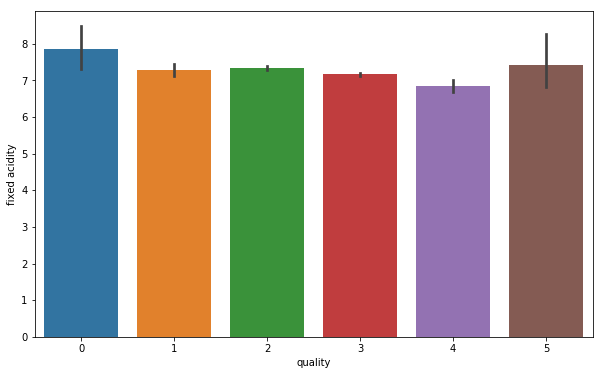

In [21]:
# plot quality vs foxed acidity
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'fixed acidity', data = wine)


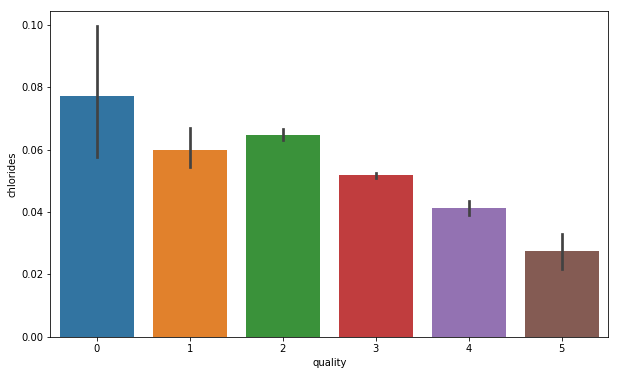

In [22]:
# As expected chlorides have a visible inpact on the quality of the wines. The less the better?

fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'chlorides', data = wine)

In [23]:
## Save the dataset for Neural Nets
wine.to_csv('wine_preprocessed.csv', header = None)


### Neural Net




In [24]:


class ActivationFunction:

    __metaclass__ = ABCMeta
    
    @abstractmethod 
    def transfer(self, activation):
       
        raise NotImplementedError()
    
    @abstractmethod
    def transfer_derivative(self, output):
        '''
        Calculate the derivative of an neuron output.
        Given an output value from a neuron, we need to calculate it's slope.
        '''
        raise NotImplementedError()

In [25]:
class Splitting:
        
    def cross_validation_split(self, dataset, n_folds):
        '''
        Split a dataset into k folds
        '''        
        dataset_split = list()
        dataset_copy = list(dataset)
        fold_size = int(len(dataset) / n_folds)
        for i in range(n_folds):
            fold = list()
            while len(fold) < fold_size:
                index = randrange(len(dataset_copy))
                fold.append(dataset_copy.pop(index))
            dataset_split.append(fold)
        return dataset_split

In [26]:
class ReLU(ActivationFunction):

    def transfer(self, activation):
        '''
        Rectified Linear Unit activation function.
        '''
        if(activation < 0):
            return 0
        elif(activation >= 0):
            return activation
    
    def transfer_derivative(self, output):
        '''
        We are using the Rectified Linear Unit transfer function, the derivative of which can be calculated as follows:
        
        '''
        if(output < 0):
            return 0
        elif(output >= 0):
            return 1



In [27]:
class MultilayerNnClassifier:
    
    def initialize_network_old(self, n_inputs, n_hidden, n_outputs):
        '''
        Initialize a new neural network ready for training. 
        It accepts three parameters, the number of inputs, the number of neurons 
        to have in the hidden layer and the number of outputs.
        '''
        network = list()
        # hidden layer has 'n_hidden' neuron with 'n_inputs' input weights plus the bias
        hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
        network.append(hidden_layer)
        output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
        network.append(output_layer)
        return network
    
    def initialize_network(self, n_inputs, n_hidden, n_outputs):
        '''
        Initialize a new neural network ready for training. 
        It accepts three parameters, the number of inputs, the hidden layers and the number of outputs.
        '''
        network = list()
        h = 0
        for hidden in n_hidden:     
            if(h==0):       
                # hidden layer has 'hidden' neuron with 'n_inputs' input weights plus the bias
                hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(hidden)]
            else:
                # hidden layer has 'hidden' neuron with 'hidden - 1' weights plus the bias
                hidden_layer = [{'weights':[random() for i in range(n_hidden[h-1] + 1)]} for i in range(hidden)]
            network.append(hidden_layer)
            h += 1
        # output layer has 'n_outputs' neuron with 'last hidden' weights plus the bias    
        output_layer = [{'weights':[random() for i in range(n_hidden[-1] + 1)]} for i in range(n_outputs)]
        network.append(output_layer)
        return network
    
    def activate(self, weights, inputs):
        '''
        Calculate neuron activation for an input is the First step of forward propagation
        activation = sum(weight_i * input_i) + bias.
        '''
        activation = weights[-1]  # Bias
        for i in range(len(weights) - 1):
            activation += weights[i] * inputs[i]
        return activation
    
    def forward_propagate(self, network, activation_function, row):
        '''
        Forward propagate input to a network output.
        The function returns the outputs from the last layer also called the output layer.
        '''
        inputs = row
        for layer in network:
            new_inputs = []
            for neuron in layer:
                activation = self.activate(neuron['weights'], inputs)
                neuron['output'] = activation_function.transfer(activation)
                new_inputs.append(neuron['output'])
            inputs = new_inputs
        return inputs
    
    def backward_propagate_error(self, network, activation_function, expected):
        '''
        Backpropagate error and store in neurons.
        
        The error for a given neuron can be calculated as follows:
        
            error = (expected - output) * transfer_derivative(output)
            
        Where expected is the expected output value for the neuron, 
        output is the output value for the neuron and transfer_derivative() 
        calculates the slope of the neuron's output value.
        
        The error signal for a neuron in the hidden layer is calculated as:
        
            error = (weight_k * error_j) * transfer_derivative(output)
            
        Where error_j is the error signal from the jth neuron in the output layer, 
        weight_k is the weight that connects the kth neuron to the current neuron 
        and output is the output for the current neuron.
        '''
        for i in reversed(range(len(network))):
            layer = network[i]
            errors = list()
            if i != len(network) - 1:
                for j in range(len(layer)):
                    error = 0.0
                    for neuron in network[i + 1]:
                        error += (neuron['weights'][j] * neuron['delta'])
                    errors.append(error)
            else:
                for j in range(len(layer)):
                    neuron = layer[j]
                    errors.append(expected[j] - neuron['output'])
            for j in range(len(layer)):
                neuron = layer[j]
                neuron['delta'] = errors[j] * activation_function.transfer_derivative(neuron['output'])
    
    def update_weights(self, network, row, l_rate):
        '''
        Updates the weights for a network given an input row of data, a learning rate 
        and assume that a forward and backward propagation have already been performed.
        
            weight = weight + learning_rate * error * input
            
        Where weight is a given weight, learning_rate is a parameter that you must specify, 
        error is the error calculated by the back-propagation procedure for the neuron and 
        input is the input value that caused the error.
        '''
        for i in range(len(network)):
            inputs = row[:-1]
            if i != 0:
                inputs = [neuron['output'] for neuron in network[i - 1]]
            for neuron in network[i]:
                for j in range(len(inputs)):
                    neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
                neuron['weights'][-1] += l_rate * neuron['delta']
    
    def train_network(self, network, activation_function, train, l_rate, n_epoch, n_outputs):
        '''
        Train a network for a fixed number of epochs.
        The network is updated using stochastic gradient descent.
        '''
        for epoch in range(n_epoch + 1):
            sum_error = 0
            for row in train:
                # Calculate Loss
                outputs = self.forward_propagate(network, activation_function, row)
                expected = [0 for i in range(n_outputs)]
                expected[row[-1]] = 1  # Bias
                sum_error += sum([(expected[i] - outputs[i]) ** 2 for i in range(len(expected))])
                self.backward_propagate_error(network, activation_function, expected)
                self.update_weights(network, row, l_rate)
            if (epoch % 100 == 0):    
                print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error/float(len(train))))
    
    def predict(self, network, activationFunction, row):
        '''
        Make a prediction with a network.
        We can use the output values themselves directly as the probability of a pattern belonging to each output class.
        It may be more useful to turn this output back into a crisp class prediction. 
        We can do this by selecting the class value with the larger probability. 
        This is also called the arg max function.
        '''
        outputs = self.forward_propagate(network, activationFunction, row)
        return outputs.index(max(outputs))
    
    def back_propagation(self, train, test, l_rate, n_epoch, n_hidden, activationFunction):
        '''
        Backpropagation Algorithm With Stochastic Gradient Descent
        '''
        n_inputs = len(train[0]) - 1
        n_outputs = len(set([row[-1] for row in train]))
        network = self.initialize_network(n_inputs, n_hidden, n_outputs)
        self.train_network(network, activationFunction, train, l_rate, n_epoch, n_outputs)
        predictions = list()
        for row in test:
            prediction = self.predict(network, activationFunction, row)
            predictions.append(prediction)
        return(predictions)

if __name__ == '__main__':    
    
    seed(1)
    mlp = MultilayerNnClassifier()
    activationFunction = ReLU()
    network = mlp.initialize_network(2, [10,5], 2)
    for layer in network:
        print(layer)
       
    # Test forward_propagate
    print("Test Forward")
    row = [1, 0, None]
    output = mlp.forward_propagate(network, activationFunction, row)
    print(output)
    
    # Test backward_propagate_error
    print("Test backpropagation of error")
    network = [[{'output': 0.7105668883115941, 'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]}],
            [{'output': 0.6213859615555266, 'weights': [0.2550690257394217, 0.49543508709194095]}, {'output': 0.6573693455986976, 'weights': [0.4494910647887381, 0.651592972722763]}]]
    expected = [0, 1]
    mlp.backward_propagate_error(network, activationFunction, expected)
    for layer in network:
        print(layer)
      
    # Test training backprop algorithm
    print("Test training backprop algorithm")
    seed(1)
    dataset = [[2.7810836, 2.550537003, 0],
        [1.465489372, 2.362125076, 0],
        [3.396561688, 4.400293529, 0],
        [1.38807019, 1.850220317, 0],
        [3.06407232, 3.005305973, 0],
        [7.627531214, 2.759262235, 1],
        [5.332441248, 2.088626775, 1],
        [6.922596716, 1.77106367, 1],
        [8.675418651, -0.242068655, 1],
        [7.673756466, 3.508563011, 1]]
    n_inputs = len(dataset[0]) - 1
    n_outputs = len(set([row[-1] for row in dataset]))
    network = mlp.initialize_network(n_inputs, [2], n_outputs)
    mlp.train_network(network, activationFunction, dataset, 0.5, 20, n_outputs)    
    for layer in network:
        print(layer)
    for row in dataset:
        prediction = mlp.predict(network, activationFunction, row)
        print('Expected=%d, Got=%d' % (row[-1], prediction))     



[{'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]}, {'weights': [0.2550690257394217, 0.49543508709194095, 0.4494910647887381]}, {'weights': [0.651592972722763, 0.7887233511355132, 0.0938595867742349]}, {'weights': [0.02834747652200631, 0.8357651039198697, 0.43276706790505337]}, {'weights': [0.762280082457942, 0.0021060533511106927, 0.4453871940548014]}, {'weights': [0.7215400323407826, 0.22876222127045265, 0.9452706955539223]}, {'weights': [0.9014274576114836, 0.030589983033553536, 0.0254458609934608]}, {'weights': [0.5414124727934966, 0.9391491627785106, 0.38120423768821243]}, {'weights': [0.21659939713061338, 0.4221165755827173, 0.029040787574867943]}, {'weights': [0.22169166627303505, 0.43788759365057206, 0.49581224138185065]}]
[{'weights': [0.23308445025757263, 0.2308665415409843, 0.2187810373376886, 0.4596034657377336, 0.28978161459048557, 0.021489705265908876, 0.8375779756625729, 0.5564543226524334, 0.6422943629324456, 0.1859062658947177, 0.992543412176065

In [28]:
class ClassificationEvaluator:
        
    def accuracy_metric(self, actual, predicted):
        '''
        Calculate accuracy percentage
        '''
        correct = 0
        for i in range(len(actual)):
            if actual[i] == predicted[i]:
                correct += 1
        return correct / float(len(actual)) * 100.0
    
    def evaluate_algorithm(self, dataset, splitting, algorithm, n_folds, *args):
        '''
        Evaluate an algorithm using a cross validation split
        '''
        folds = splitting.cross_validation_split(dataset, n_folds)
        scores = list()
        for fold in folds:
            train_set = list(folds)
            train_set.remove(fold)
            train_set = sum(train_set, [])
            test_set = list()
            for row in fold:
                row_copy = list(row)
                test_set.append(row_copy)
                row_copy[-1] = None
            print('>train size=%d' % (len(train_set)))
            print('>test size=%d' % (len(test_set)))    
            predicted = algorithm(train_set, test_set, *args)
            actual = [row[-1] for row in fold]
            accuracy = self.accuracy_metric(actual, predicted)
            print('>accuracy=%.3f' % (accuracy))
            scores.append(accuracy)
        return scores   





In [ ]:

from csv import reader

class DataPreparation:
     
    def load_csv(self, filename):
        '''
        Load a CSV file
        '''
        dataset = list()
        with open(filename, 'r') as file:
            csv_reader = reader(file)
            for row in csv_reader:
                if not row:
                    continue
                dataset.append(row)
        return dataset
    def str_column_to_float(self, dataset, column):
        '''
        Convert string column to float
        '''
        for row in dataset:
            row[column] = float(row[column].strip())
     
    def str_column_to_int(self, dataset, column):
        '''
        Convert string column to integer
        '''
        class_values = [row[column] for row in dataset]
        unique = set(class_values)
        lookup = dict()
        for i, value in enumerate(unique):
            lookup[value] = i
        for row in dataset:
            row[column] = lookup[row[column]]
        return lookup
    
    def dataset_minmax(self, dataset):
        '''
        Find the min and max values for each column
        '''    
        stats = [[min(column), max(column)] for column in zip(*dataset)]
        self.stats = stats
        return stats

    def normalize_dataset_classification(self, dataset, minmax):
        '''
        Rescale dataset columns to the range 0-1
        '''    
        for row in dataset:
            for i in range(len(row) - 1):
                row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
    
    def denormalize_dataset_classification(self, dataset, minmax):
        '''
        Rescale dataset columns to the original range
        '''    
        for row in dataset:
            for i in range(len(row) - 1):
                row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])            
    
    def normalize_dataset_regression(self, dataset, minmax):
        '''
        Rescale dataset columns to the range 0-1
        '''    
        for row in dataset:
            for i in range(len(row)):
                row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])     

def classificationWineRed():
    '''
    Test Classification on WineRed dataset
    '''
        
    seed(1)
    
    n_folds = 5
    l_rate = 0.3
    n_epoch = 1000
    n_hidden = [10]
    
    mlp = MultilayerNnClassifier();
    activationFunction = ReLU()
    dp = DataPreparation();
    evaluator = ClassificationEvaluator();
    splitting = Splitting();
        
    # Test Backprop on Seeds dataset
    # load and prepare data
    filename = 'wine_preprocessed.csv'
    
    dataset = dp.load_csv(filename)
    
    for i in range(len(dataset[0]) - 1):
        dp.str_column_to_float(dataset, i)
    # convert class column to integers
    dp.str_column_to_int(dataset, len(dataset[0]) - 1)
    # normalize input variables
    minmax = dp.dataset_minmax(dataset)
    dp.normalize_dataset_classification(dataset, minmax)    
    # evaluate algorithm
    scores = evaluator.evaluate_algorithm(dataset, splitting, mlp.back_propagation, n_folds, l_rate, n_epoch, n_hidden, activationFunction)  
    print_classification_scores(scores)  
    
def print_classification_scores(scores):
    print('Scores: %s' % scores)
    print('Mean Accuracy: %.3f%%' % (sum(scores) / float(len(scores))))   
        
if __name__ == '__main__':
    
    options = {

           1 : classificationWineRed,
           
           }
    
    var = input("For training print 1.")
    print("You entered " + str(var))
    
options[int(var)]()  